In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython.display as display
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models,transforms, datasets
from torch.utils.data import dataloader

/home/morita/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import sys
sys.path.append("../src/libs/")

In [4]:
from transform import BaseTransform

In [6]:
print("Pytorch Version: ", torch.__version__)
print("Torchvision Version:", torchvision.__version__)

Pytorch Version:  1.7.0
Torchvision Version: 0.8.0


In [8]:
filepath = "../data/rad_cnt/"
df = pd.read_csv(filepath+"result0.csv", header=None)
df.columns = ["x", "y", "z", "value", "type"]
source = df[df['type'] == 'source_data']
print(source)
sensor_data = df = df[df['type'] != 'source_data']
print(sensor_data)

      x    y    z        value         type
0   8.5  0.5  0.0  2719.859619  source_data
1  10.5  5.5  0.0  8113.486328  source_data
           x     y    z       value type
2       0.05  0.05  0.5   96.157524  NaN
3       0.15  0.05  0.5   97.948441  NaN
4       0.25  0.05  0.5   99.790588  NaN
5       0.35  0.05  0.5  101.685997  NaN
6       0.45  0.05  0.5  103.636848  NaN
...      ...   ...  ...         ...  ...
13997  13.55  9.95  0.5  300.031860  NaN
13998  13.65  9.95  0.5  294.107239  NaN
13999  13.75  9.95  0.5  288.240753  NaN
14000  13.85  9.95  0.5  282.439758  NaN
14001  13.95  9.95  0.5  276.710785  NaN

[14000 rows x 5 columns]


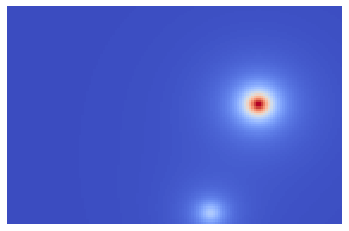

In [9]:
min_value = sensor_data['value'].min()
max_value = sensor_data['value'].max()
sensor_data['value_normalized'] = (sensor_data['value'] - min_value) / (max_value - min_value)
source_heatmap = sensor_data.pivot('y', 'x', 'value_normalized')
sns.heatmap(source_heatmap, cmap='coolwarm', cbar=False, xticklabels=False, yticklabels=False)
plt.gca().invert_yaxis() #invert y axis
plt.xlabel('')
plt.ylabel('')
plt.savefig('../data/img/result2.jpg', format="jpg", bbox_inches='tight', pad_inches=0)
plt.show()

In [10]:
img = Image.open("../data/img/result2.jpg")

In [11]:
transform = BaseTransform()
img_transformed = transform(img)

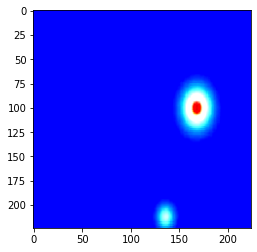

In [12]:
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

## Result

      x    y  value_normalized
0   8.5  0.5          0.335227
1  10.5  5.5          1.000000


/home/morita/.local/lib/python3.8/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/morita/.local/lib/python3.8/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


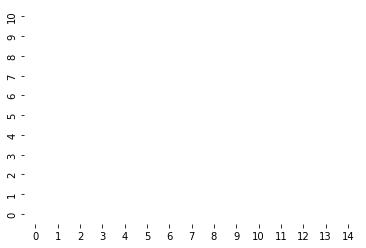

In [13]:
max_value_source = source['value'].max()
source['value_normalized'] = source['value'] / max_value_source
print(source[['x', 'y', 'value_normalized']])
source_heatmap = source.pivot(index = 'y', columns = 'x', values= 'value_normalized')
source_heatmap = source_heatmap.reindex(range(11), columns=range(15))
sns.heatmap(source_heatmap, cmap='coolwarm', cbar=False)
plt.gca().invert_yaxis() #invert y axis
plt.xlabel('')
plt.ylabel('')
plt.savefig('../data/cor_img/cor2.jpg', format="jpg", bbox_inches='tight', pad_inches=0)
plt.show()

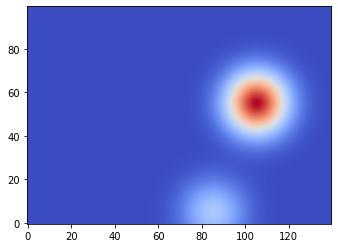

In [14]:
# 2Dグリッドの作成
x_range = np.arange(0, 14, 0.1)  # x座標の範囲
y_range = np.arange(0, 10, 0.1)  # y座標の範囲
X, Y = np.meshgrid(x_range, y_range)


# 3D正規分布の計算と重ね合わせ
pdf = np.zeros_like(X)
for i in range(len(source)):
    xi, yi, value = source['x'][i], source['y'][i], source['value_normalized'][i]
    sigma = 1.0  # 標準偏差（適切な値に調整）
    pdf += (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((X - xi)**2 + (Y - yi)**2) / (2 * sigma**2)) * value

# 2Dヒートマップの表示
plt.imshow(pdf, cmap='coolwarm',origin = "lower")
plt.show()


# GAN

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, np.prod(img_dim)),
            nn.Tanh()
        )
        self.img_dim = img_dim

    def forward(self, z):
        img = self.fc(z)
        return img.view(img.size(0), *self.img_dim)